# UK Commerce 데이터를 이용한 리포트 작성

## 상품별 첫 고매 고객 수

* 첫 구매가 가장 많이 이루어진 상품을 찾을 수 있다면 첫 구매를 유도한 상품의 특징을 파악할 수 있을 것이다.
* 고객별로 구매일 기준으로 순위를 생성하면, 고객의 최초 구매 상품을 조회할 수 있다.
* 다음으로 최초 구매 상품으로 데이터를 그룹핑하고 고객 수를 집계하면, 상품별로 최초 구매 고객 수를 계산할 수 있다.

### 1. 고객별, 상품별 첫 구매 일자

In [ ]:
# 고객별, 상품별 첫 구매 일자
SELECT CustomerID, StockCode, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY 1, 2;

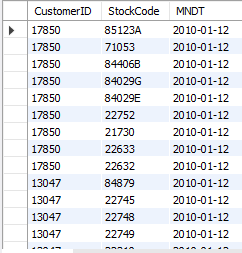

### 2. 고객별 구매와 기준 순위 생성(랭크)

* 계산 결과를 기준으로 순위를 생성해야 하므로, 앞에서 작성한 쿼리를 서브쿼리로 생성하고 순위 열을 생성한다.

In [ ]:
# 서브쿼리로 생성하고 순위 열을 생성
SELECT *,
ROW_NUMBER() OVER(PARTITION BY CustomerID ORDER BY MNDT) RNK
FROM
(SELECT CustomerID, StockCode, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY 1, 2) A;

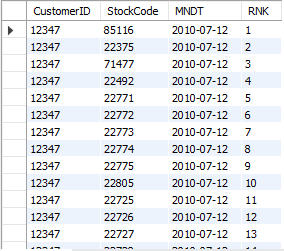

#### a. 고객별 첫 구매 내역 조회

* 순위 열의 값이 1인 조건을 생성해야 한다. 여기서 순위 열은 SELECT 구문에서 새롭게 생성한 열이므로 앞선 쿼리를 서브 쿼리로 다시 생성해 WHERE절에 조건을 추가해야 한다.

In [ ]:
-- 순위 열의 값이 1인 조건을 생성
SELECT *
FROM
(SELECT *,
ROW_NUMBER() OVER(PARTITION BY CustomerID ORDER BY MNDT) RNK
FROM
(SELECT CustomerID, StockCode, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY 1, 2) A) A
WHERE RNK = 1;

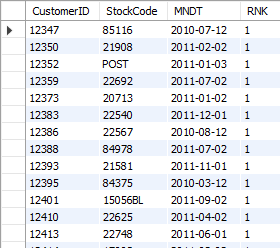

#### b. 상품별 첫 구매 고객 수 집계

In [ ]:
# 상품별 첫 구매 고객 수 집계
SELECT StockCode, COUNT(DISTINCT CustomerID) First_BU
FROM
(SELECT *
FROM
(SELECT *,
ROW_NUMBER() OVER(PARTITION BY CustomerID ORDER BY MNDT) RNK
FROM
(SELECT CustomerID, StockCode, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY 1, 2) A) A
WHERE RNK = 1) A
GROUP BY StockCode
ORDER BY 2 DESC;

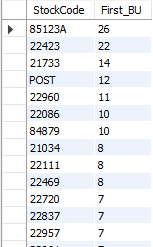

## 첫 구매 후 이탈하는 고객의 비중

* 신규로 유입된 고객이 계속 서비스를 이용할 수 있도록 유도하기 위해서는 얼마나 많은 고객이 이탈하는지를 측정할 필요가 있다.
* 쿼리를 작성하기 전에 절차를 생각해 본다.

In [ ]:
# 테이블 조회
SELECT * FROM dataset3;

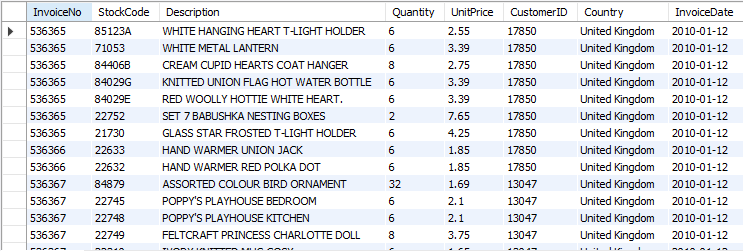

* 해당 데이터에는 고객 번호와 구매일자가 존재한다.
* 첫 구매를 하고 이탈해 버린 고객의 데이터는 구매일자값이 하나만 존재할 것이다.
* 즉, 고객별로 구매일자의 중복을 제거하고 카운트했을 때, 1의 값을 갖는 고객은 첫 구매를 하고 이탈한 고객이 된다.
* 먼저 고객별 구매 일자의 중복을 제거하고 카운트해 본다.

In [ ]:
# 고객별 구매 일자의 중복 제거하고 카운트
SELECT CustomerID, COUNT(DISTINCT InvoiceDate) F_Date
FROM dataset3
GROUP BY 1;

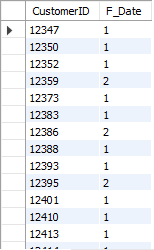

* F_Date의 값이 1인 고객번호는 첫 구매 후 이탈한 고객들이다.
* F_Date가 1인 고객의 수를 카운트해 그 값을 전체 고객의 수로 나누면, 첫 구매 후 이탈한 고객 수를 계산할 수 있다.

In [ ]:
# 첫 구매 후 이탈한 고객 수를 계산
SELECT SUM(CASE WHEN F_Date = 1 THEN 1 ELSE 0 END) / SUM(1) Bounc_Rate
FROM
(SELECT CustomerID, COUNT(DISTINCT InvoiceDate) F_Date
FROM dataset3
GROUP BY 1) A;

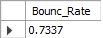

* 첫 구매 후 이탈한 고객의 비중은 약 73%이다. 다음으로 국가별 첫 구매 후 이탈 고객의 비중을 계산해본다.
* 국가별 첫 구매 후 이탈 고객 역시 앞의 과정과 유사하다. 국가로 데이터를 그룹핑한 뒤 집계과정을 추가해주면 된다.

In [ ]:
# 국가별 첫 구매 후 이탈 고객의 비중
SELECT Country, SUM(CASE WHEN F_Date = 1 THEN 1 ELSE 0 END) / SUM(1) Bounc_Rate
FROM
(SELECT CustomerID, Country, COUNT(DISTINCT InvoiceDate) F_Date
FROM dataset3
GROUP BY 1, 2) A
GROUP BY 1
ORDER BY Country;

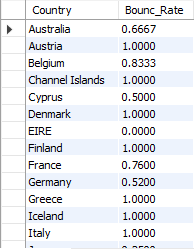

## 판매 수량이 20%이상 증가한 상품 리스트(YTD)

* 해당 데이터 세트의 판매 기간은 2010~2011년으로 구성되어 있다.
* 2010년 대비 2011년 판매 수량이 20%이상 증가한 상품을 찾도록 먼저 연도별, 상품별 판매 수량을 계산한다.

### 1. 2011년도 상품별 판매 수량

In [ ]:
# 2011년도 상품별 판매 수량
SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2011'
GROUP BY 1;

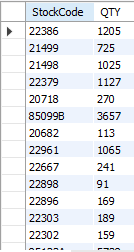

### 2. 2010년도 상품별 판매 수량

In [ ]:
# 2010년도 상품별 판매 수량
SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2010'
GROUP BY 1;

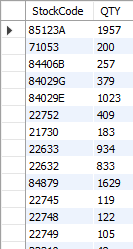

* 2011년도 상품별 판매 수량 테이블에 2010년도 상품별 판매 수량 테이블을 결합한다.

In [ ]:
# 2011년도 상품별 판매 수량 테이블에 2010년도 상품별 판매 수량 테이블 결합
SELECT *
FROM
(SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2011'
GROUP BY 1) A
LEFT JOIN
(SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2010'
GROUP BY 1) B
ON A.StockCode = B.StockCode;

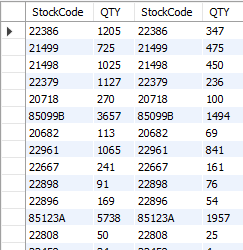

* 출력내용 정리를 위해 상품코드, 2011년 판매 수량, 2010년 판매 수량을 구하고 2010년 대비 증가율을 계산한다.

In [ ]:
# 상품코드, 2011년 판매 수량, 2010년 판매 수량을 구하고 2010년 대비 증가율 계산
SELECT A.StockCode, A.QTY, B.QTY, A.QTY/B.QTY-1 QTY_Increase_Rate
FROM
(SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2011'
GROUP BY 1) A
LEFT JOIN
(SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2010'
GROUP BY 1) B
ON A.StockCode = B.StockCode;

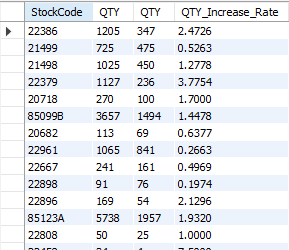

* 마지막으로 2010년 대비 2011년 증가율이 0.2 이상인 경우로 조건을 생성한다.
* QTY_Increase_Rate가 SELECT에 존재하므로, WHERE절에서 바로 사용할 수 없다. 그러므로 서브쿼리를 생성해서 WHERE절에 해당 컬럼을 사용할 수 있다.

In [ ]:
# 2010년 대비 2011년 증가율이 0.2 이상인 경우로 조건 생성
SELECT *
FROM
(SELECT A.StockCode, A.QTY QTY_2011, B.QTY QTY_2010, A.QTY/B.QTY-1 QTY_Increase_Rate
FROM
(SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2011'
GROUP BY 1) A
LEFT JOIN
(SELECT StockCode, SUM(Quantity) QTY
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2010'
GROUP BY 1) B
ON A.StockCode = B.StockCode) BASE
WHERE QTY_Increase_Rate >= 1.2;

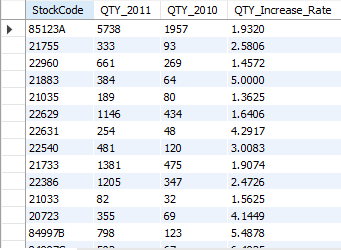

## 주차별 매출액

* WEEKOFYEAR: 일자의 주차를 숫자로 변환한다.
* WEEKOFYEAR 함수를 이용하면, 해당 일자의 주차를 구할 수 있다.

* 2011년 주차별 매출액을 계산한다.

In [ ]:
# 2011년 주차별 매출액 계산
SELECT WEEKOFYEAR(InvoiceDate) WK,
SUM(Quantity*UnitPrice) Sales
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2011'
GROUP BY 1
ORDER BY 1;

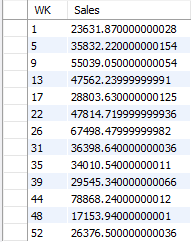

## 신규/기존 고객의 2011년 월별 매출액

* 신규 고객의 증가량과 활동량은 서비스의 흥망성쇠를 가늠하는 지표로 사용될 수 있다.
* 매출을 신규 고객과 기존 고객으로 구분해 계산해보고자 한다.
* 신규 고객은 2011년에 첫 구매를 한 고객, 기존 고객은 2010년에 구매한 적이 있는 고객으로 설정
* 먼저 각 고객을 신규 고객과 기존 고객으로 구별해야 한다. 고객별로 최초 구매 일자를 구하고, 최초 구매 연도가 2011년이면 신규 고객, 2010년이면 기존 고객으로 분류한다.

In [ ]:
# 각 고객을 신규 고객과 기존 고객으로 구별
SELECT CASE WHEN SUBSTR(MNDT, 1, 4) = '2011' THEN 'NEW' ELSE 'EXI' END New_EXI,
CustomerID
FROM
(SELECT CustomerID, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY 1) A;

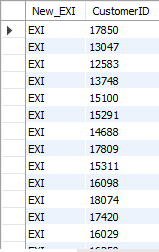

* 신규, 기존으로 구분되게 설정했으므로 해당 테이블을 매출 테이블에 조인해본다.

In [ ]:
# 신규, 기존으로 구분되게 설정했으므로 해당 테이블을 매출 테이블에 조인
SELECT A.CustomerID, B.NEW_EXI, A.InvoiceDate, A.UnitPrice, A.Quantity
FROM dataset3 A
LEFT JOIN
(SELECT CASE WHEN SUBSTR(MNDT, 1, 4) = '2011' THEN 'NEW' ELSE 'EXI' END New_EXI,
CustomerID
FROM
(SELECT CustomerID, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY 1) A) B
ON A.CustomerID = B.CustomerID
WHERE SUBSTR(A.InvoiceDate, 1, 4) = '2011';

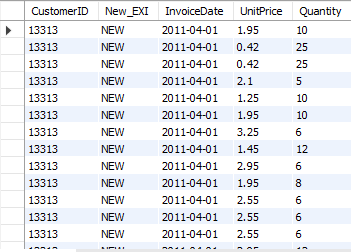

* 고객 신규/기존 테이블은 CustomerID가 Unique해 2개 테이블을 조합해도 데이터가 중복으로 생성되지 않는다.
* 조인을 하더라도 매출이 뻥튀기되는 현상은 발생하지 않는다.
* 2011년 매출을 신규, 기존으로 나누어 보는 것이므로 2011년도의 매출로 한정해 데이터를 추출한다.
* 조인 결과를 월, 신규/기존으로 구분해 매출을 집계한다.

In [ ]:
# 조인 결과를 월, 신규/기존으로 구분해 매출 집계
SELECT B.NEW_EXI, SUBSTR(A.InvoiceDate, 1, 7) MM,
SUM(A.UnitPrice*A.Quantity) Sales
FROM dataset3 A
LEFT JOIN
(SELECT CASE WHEN SUBSTR(MNDT, 1, 4) = '2011' THEN 'NEW' ELSE 'EXI' END New_EXI,
CustomerID
FROM
(SELECT CustomerID, MIN(InvoiceDate) MNDT
FROM dataset3
GROUP BY 1) A) B
ON A.CustomerID = B.CustomerID
WHERE SUBSTR(A.InvoiceDate, 1, 4) = '2011'
GROUP BY 1, 2;

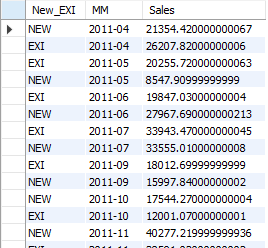

## 기존 고객의 2011년 월 누적 리텐션

* 월 누적 리텐션: 2010년에 구매한 고객의 2011년 월별 누적 리텐션을 의미
* 예를 들어, 2010년에 구매한 고객의 수가 100명이라고 할 때, 100명 중 2011년 1월에 구매한 고객은 10명, 2월까지 구매한 고객은 15명이라고 한다면 1월의 누적 리텐션은 10%, 2월의 누적 리텐션은 15%가 된다.
* 해당 수치를 SQL에서 바로 추출하기는 힘들다. 기존 고객의 2011년도 첫 구매 월을 계산한 뒤 첫 월별 고객 수를 계산해 액셀이나 R, Python을 통해 이를 누적하는 것이 간단한 방법이다.

* 먼저 기존 고객 리스트를 만들어본다.

In [ ]:
# 기존 고객 리스트
SELECT CustomerID
FROM dataset3
GROUP BY 1
HAVING MIN(SUBSTR(InvoiceDate, 1, 4)) = '2010';

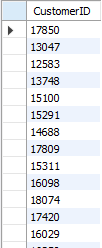

* 기존 고객들의 2011년 구매 내역을 조회해본다.

In [ ]:
# 기존 고객들의 2011년 구매 내역 조회
SELECT *
FROM dataset3
WHERE CustomerID IN
(SELECT CustomerID
FROM dataset3
GROUP BY 1
HAVING MIN(SUBSTR(InvoiceDate, 1, 4)) = '2010')
AND SUBSTR(InvoiceDate, 1, 4) = '2011';

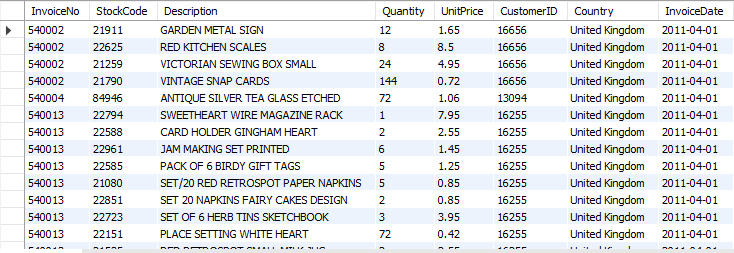

* 고객별로 첫 구매 월을 계산해본다.

In [ ]:
# 고객별로 첫 구매 월 계산
SELECT CustomerID, SUBSTR(InvoiceDate, 1, 7) MM
FROM
(SELECT *
FROM dataset3
WHERE CustomerID IN
(SELECT CustomerID
FROM dataset3
GROUP BY 1
HAVING MIN(SUBSTR(InvoiceDate, 1, 4)) = '2010')
AND SUBSTR(InvoiceDate, 1, 4) = '2011') A
GROUP BY 1;

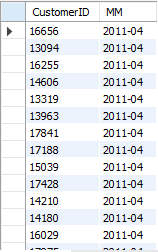

* 첫 구매 월로 그룹핑한 뒤 CustomerID를 집계해준다.

In [ ]:
# 첫 구매 월로 그룹핑한 뒤 CustomerID 집계
SELECT MM, COUNT(CustomerID) N_Customers
FROM
(SELECT CustomerID, SUBSTR(InvoiceDate, 1, 7) MM
FROM
(SELECT *
FROM dataset3
WHERE CustomerID IN
(SELECT CustomerID
FROM dataset3
GROUP BY 1
HAVING MIN(SUBSTR(InvoiceDate, 1, 4)) = '2010')
AND SUBSTR(InvoiceDate, 1, 4) = '2011') A
GROUP BY 1, 2) A
GROUP BY 1
ORDER BY 1;

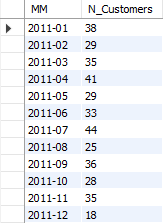

* 기존 고객 수는 다음과 같은 방법으로 계산할 수 있다.

In [ ]:
# 기존 고객 수 계산
SELECT COUNT(*) N_Customers
FROM
(SELECT CustomerID FROM dataset3
GROUP BY 1
HAVING MIN(SUBSTR(InvoiceDate, 1, 4)) = '2010') A;

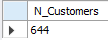

## LTV(Life Time Value)

* CLTV, LTV로 자주 표현되며 주로 마케팅에서 사용되는 개념이다.
* 고객과의 미래 관계를 고려해 귀속되는 순이익을 예측하는 지표이다.
* 머신러닝 모델, 로지스틱 회귀모형과 같이 복잡한 방법론을 이용해 구할 수도 있으나 SQL을 이용해 고객의 리텐션과 평균 거래 단가 등을 고려해 2011년 구매자의 CLTV를 간단히 구해보고자 한다.

* **AMV(Average Member Value)**: 전체 매출액/구매 고객 수
* **Retention Rate**: t1 and t0 구매 고객 수/t0시점 구매 고객 수
* AMV는 인당 평균 얼마의 금액을 지불하는지를 나타내는 지표고, Retention Rate는 다음 Time Interval에 몇%의 고객이 구매하는지를 나타내는 지표이다.
* t2 시점을 끝이라고 볼 때 t2시점에 예상되는 매출액을 구하고자 하면, t1의 구매 고객 수*Retention Rate를 구하면, t2 시점의 예상 구매 고객 수를 계산할 수 있다.
* 여기에 AMV(인당 평균 구매 금액)를 곱하면, t2의 예상 매출액을 계산할 수 있다.

* 이제 AMV와 Retention Rate을 계산해보고자 한다.
* Retention Rate는 2010년 구매자 중 2011년에 구매한 고객의 비율로 계산할 수 있다.

In [ ]:
# Retention Rate: 2010년 구매자 중 2011년에 구매한 고객의 비율로 계산
SELECT COUNT(B.CustomerID)/COUNT(A.CustomerID) Retention_Rate
FROM
(SELECT DISTINCT CustomerID
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2010') A
LEFT JOIN
(SELECT DISTINCT CustomerID
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2011') B
ON A.CustomerID = B.CustomerID;

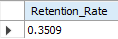

* AMV는 전체 매출을 구매자 수로 나누어 계산한다.

In [ ]:
# AMV 계산
SELECT SUM(UnitPrice*Quantity)/COUNT(DISTINCT CustomerID) AMV
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2011';

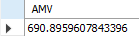

* 2011년도 구매자 수를 계산하고, 예상 구매자 수를 계산한다.

In [ ]:
# 2011년도 구매자 수 계산
SELECT COUNT(DISTINCT CustomerID) N_BU
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2011';

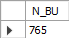

* 2011년의 구매자 수는 총 765명이다.
* 2012년의 예상 구매자 수는 2011년 구매자 수*Retention Rate(%)로 예상해 볼 수 있다.
* 즉, 765 * 0.3509 = 268.4385명이 2012년에도 구매할 것으로 예상된다.
* 2012년 예성 구매자들이 2012년에 총 얼마의 매출을 발생시키는지 알기 위해서 예상구매자 수(268.4385) * AMV(690) = 185463.0753..으로 계산된다.
* 2011년 구매자가 전체 기간에 발생시킬 매출의 합은 2011년 매출액+2011년 구매자의 2012년 예상 매출액을 합하면, 2011구매자의 LTV를 계산해볼 수 있을 것이다.

* 2011년 매출액은 다음과 같이 구할 수 있다.

In [ ]:
# 2011년 매출액
SELECT SUM(UnitPrice*Quantity) Sales_2011
FROM dataset3
WHERE SUBSTR(InvoiceDate, 1, 4) = '2011';

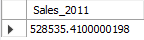

* 2011년 매출액 + 2011년 구매자의 2012년 예상 매출액 = 528535 + 185463 = 713998이다.
* 해당 금액을 2011년 구매자 수로 나누면, 2011년 구매자의 가치 LTV를 계산해볼 수 있다.
* 2011년 구매자의 생애 매출/2011년 구매자 수 = 713998/765 = 933.331...이다.
* 즉 2011년의 LTV는 약 933으로 계산된다. 동일한 방법으로 2010년 LTV를 구할 수 있을 것이다.
* 고객의 세그먼트별로 LTV를 계산해 본다면, 어떤 고객이 우리 서비스에서 가장 가치 있는 고객인지 측정해 볼 수 있을 것이다.